In [4]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

MODEL_NAME = "Rostlab/prot_bert" 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # using mps instead of cuda for training on mac
#DEVICE = "cpu"  # use GPU if available, otherwise CPU
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001

Using device: mps


In [7]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [8]:
df = df_raw[~df_raw["label"].str.contains("P")]
df.describe()

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [9]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
label_seqs = df_encoded["label"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,1,20423,19036,41,16382


In [10]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [11]:
# Stratify by sequence length to avoid ValueError
train_seqs, test_seqs, train_label_seqs, test_label_seqs = train_test_split(
    sequences, label_seqs, test_size=0.3, random_state=42
)

In [12]:
# Load the data 
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # preprocess the sequence (insert spaces between amino acids)
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]
        # Tokenize the sequence (padding to ensure all sequences are the same length -> 512 tokens) 
        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Build a label tensor of the same length as input_ids.
        # For tokens beyond the original sequence length, assign -100 so that loss func ignores them.
        orig_length = len(seq)
        token_labels = []
        
        for i in range(input_ids.size(0)):
            if i == 0 or i > orig_length:  
                token_labels.append(-100)  # ignore padding tokens
            else:
                # Use the already encoded label directly
                token_labels.append(labels[i-1])
        labels_tensor = torch.tensor(token_labels)
        
        return {
            'input_ids': input_ids, # tokenized and padded 
            'attention_mask': attention_mask, # differentiate between padding and non-padding tokens
            'labels': labels_tensor # aligned label tensor
        }

train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model  
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.encoder.config.hidden_size
        # detects local features in the sequence
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=6, dilation=2, padding=5)
        self.conv2 = nn.Conv1d(in_channels=1024, out_channels=num_labels, kernel_size=3, dilation=2, padding=2)
        # 2 layer long short term memory network
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        # dense layer
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)



    def forward(self, input_ids, attention_mask, labels=None):
        # Encode with BERT
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state  # (batch, seq_len, hidden_size)

        #  CNN 1
        x = hidden_states.transpose(1, 2)                # (batch, hidden_size, seq_len)
        x_conv1 = F.relu(self.conv1(x))                  # (batch, 1024, seq_len)

        # Transpose CNN output for LSTM: (batch, seq_len, features)
        x_lstm_input = x_conv1.transpose(1, 2)           # (batch, seq_len, 1024)

        # Apply BiLSTM
        lstm_out, _ = self.lstm(x_lstm_input)            # (batch, seq_len, 1024)

        # Classifier to num_labels
        x_linear = self.classifier(lstm_out)             # (batch, seq_len, num_labels)

        # CNN 2
        x_conv2 = self.conv2(x_conv1).transpose(1, 2)
        logits = self.dropout(x_conv2 + x_linear)

        #logits = self.dropout(x_linear)                  # (batch, seq_len, num_labels)

        if labels is not None:
            loss = -self.crf(logits, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            predictions = self.crf.decode(logits, mask=attention_mask.bool())
            return predictions



In [14]:
from transformers import get_linear_schedule_with_warmup

# Initialize the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)

# optimizer 
optimizer = torch.optim.Adam([
    {"params": model.encoder.encoder.layer[-4:].parameters(), "lr": 5e-6},
    {"params": model.conv1.parameters(), "lr": 1e-3},
    {"params": model.conv2.parameters(), "lr": 1e-3},
    {"params": model.classifier.parameters(), "lr": 1e-3},
    {"params": model.crf.parameters(), "lr": 1e-3},
])

total_steps = len(train_loader) * EPOCHS
# scheduler for learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
# Counter({'I': 1204001, 'O': 362643, 'S': 85526, 'M': 74445, 'L': 46065, 'T': 22272, 'P': 951})
class_counts = [1204001, 85526, 22272, 46865, 74445, 362643]  # Count for each class (I, S, T, L, M, O)
# hopefully deals with the class imbalance
weights = torch.tensor([1.0 / count for count in class_counts], device=DEVICE)

# loss function that ignores the padding tokens (-100)
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

In [15]:
# Compute sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [16]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef

def evaluate_model(model, data_loader, loss_fn, test_label_seqs):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in tqdm(data_loader, desc="Evaluation", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), labels.reshape(-1))
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        # Flatten and filter out padding tokens (-100)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        valid_idx = labels_flat != -100
        all_preds.extend(preds_flat[valid_idx].cpu().numpy())
        all_labels.extend(labels_flat[valid_idx].cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
    
    try:
        mcc = matthews_corrcoef(all_labels, all_preds)
    except ImportError:
        mcc = None

    print("Classification Report:")
    print(report)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Token-level Accuracy: {acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc if mcc is not None else 'N/A'}")
    
    # Compute sequence-level accuracy if the function is defined
    try:
        seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
        print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")
    except Exception as e:
        seq_acc_val = None
        print("Sequence Level Accuracy could not be computed:", e)
    
    return avg_loss, acc, mcc, seq_acc_val


In [12]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm

writer = SummaryWriter(log_dir="/Users/jonas/Desktop/Uni/PBL/logs/prot_bert_linear_classifier_v4")

for param in model.encoder.parameters():
    param.requires_grad = False # if this is true then mps runs out of memory

for epoch in range(EPOCHS):

    model.train()

    # Gradually unfreeze only a subset of encoder layers for efficiency
    if epoch == 4:
        # Unfreeze only the last encoder layer
        try:
            for param in model.encoder.encoder.layer[-4:].parameters():
                param.requires_grad = True
        except Exception as e:
            print("Error unfreezing parameters in Epoch 4, switching to cpu:", e)
            model.DEVICE = "cpu"  # fallback to CPU
            continue
    elif epoch == 7:
        try:
            for param in model.encoder.parameters():            
                param.requires_grad = True
        except Exception as e:
            print("Error unfreezing parameters in Epoch 7, switching to cpu:", e)
            model.DEVICE = "cpu"  # fallback to CPU
            continue

    # progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    total_loss = 0 # total epoch loss

    for batch in pbar:
        try:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()  # resets gradients

            loss = model(input_ids, attention_mask, token_labels)  # forward pass (loss calculated in the foward method)
            loss.backward()  # backpropagation
            optimizer.step()  # update weights with optimizer
            scheduler.step() # update learning rate

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        except Exception as e:
            print("Error during training:", e)
            model.DEVICE = "cpu"  # fallback to CPU
            continue

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    
 



Epoch 1/10: 100%|██████████| 280/280 [42:48<00:00,  9.17s/batch, loss=28.3]


Epoch 1, Loss: 51.0985


Epoch 2/10: 100%|██████████| 280/280 [42:44<00:00,  9.16s/batch, loss=29.3]


Epoch 2, Loss: 25.1589


Epoch 3/10: 100%|██████████| 280/280 [42:29<00:00,  9.11s/batch, loss=9.6] 


Epoch 3, Loss: 17.0802


Epoch 4/10: 100%|██████████| 280/280 [42:49<00:00,  9.18s/batch, loss=12.6]


Epoch 4, Loss: 12.3970


Epoch 5/10:   0%|          | 1/280 [00:09<45:05,  9.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.69 GB, other allocations: 2.00 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|          | 2/280 [00:26<1:05:17, 14.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.69 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|          | 3/280 [00:47<1:19:41, 17.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.56 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|▏         | 4/280 [01:18<1:42:58, 22.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.56 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▏         | 5/280 [01:49<1:57:48, 25.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.56 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▏         | 6/280 [02:07<1:45:34, 23.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.56 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▎         | 7/280 [02:34<1:50:40, 24.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.69 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   3%|▎         | 8/280 [02:52<1:41:30, 22.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.81 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   3%|▎         | 9/280 [03:11<1:35:10, 21.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.81 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▎         | 10/280 [03:34<1:37:39, 21.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.81 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▍         | 11/280 [03:53<1:34:19, 21.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.94 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▍         | 12/280 [04:16<1:36:17, 21.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.06 GB, other allocations: 2.00 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▍         | 13/280 [04:41<1:40:46, 22.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▌         | 14/280 [05:00<1:35:10, 21.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▌         | 15/280 [05:23<1:36:53, 21.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▌         | 16/280 [05:49<1:41:44, 23.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▌         | 17/280 [06:11<1:39:50, 22.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▋         | 18/280 [06:35<1:41:34, 23.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   7%|▋         | 19/280 [06:58<1:41:00, 23.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   7%|▋         | 20/280 [07:21<1:40:01, 23.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 21/280 [07:46<1:42:40, 23.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 22/280 [08:11<1:43:48, 24.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 23/280 [08:36<1:44:29, 24.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▊         | 24/280 [09:00<1:43:33, 24.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▉         | 25/280 [09:21<1:38:55, 23.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▉         | 26/280 [09:44<1:37:22, 23.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|▉         | 27/280 [10:03<1:31:43, 21.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|█         | 28/280 [10:23<1:29:16, 21.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|█         | 29/280 [10:42<1:26:52, 20.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█         | 30/280 [11:04<1:27:18, 20.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█         | 31/280 [11:25<1:27:47, 21.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█▏        | 32/280 [11:46<1:26:57, 21.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▏        | 33/280 [12:12<1:33:12, 22.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▏        | 34/280 [12:38<1:36:25, 23.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▎        | 35/280 [13:06<1:41:11, 24.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  13%|█▎        | 36/280 [13:29<1:38:45, 24.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  13%|█▎        | 37/280 [13:55<1:40:39, 24.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▎        | 38/280 [14:24<1:44:48, 25.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▍        | 39/280 [14:53<1:47:51, 26.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▍        | 40/280 [15:22<1:50:35, 27.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▍        | 41/280 [15:45<1:44:40, 26.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▌        | 42/280 [16:12<1:45:17, 26.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▌        | 43/280 [16:36<1:40:59, 25.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▌        | 44/280 [17:02<1:42:03, 25.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▌        | 45/280 [17:29<1:42:18, 26.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▋        | 46/280 [17:55<1:41:34, 26.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  17%|█▋        | 47/280 [18:18<1:37:55, 25.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  17%|█▋        | 48/280 [18:46<1:40:29, 25.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 49/280 [19:07<1:34:09, 24.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 50/280 [19:34<1:37:03, 25.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 51/280 [19:57<1:34:15, 24.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▊        | 52/280 [20:24<1:36:27, 25.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▉        | 53/280 [20:54<1:41:04, 26.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▉        | 54/280 [21:23<1:42:37, 27.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|█▉        | 55/280 [21:47<1:38:45, 26.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|██        | 56/280 [22:17<1:42:50, 27.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|██        | 57/280 [22:41<1:38:05, 26.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██        | 58/280 [23:03<1:33:00, 25.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██        | 59/280 [23:29<1:33:14, 25.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██▏       | 60/280 [23:58<1:36:46, 26.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▏       | 61/280 [24:24<1:35:42, 26.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▏       | 62/280 [24:50<1:35:56, 26.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▎       | 63/280 [25:16<1:34:45, 26.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  23%|██▎       | 64/280 [25:48<1:40:38, 27.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  23%|██▎       | 65/280 [26:15<1:38:55, 27.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▎       | 66/280 [26:40<1:36:13, 26.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▍       | 67/280 [27:06<1:33:47, 26.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▍       | 68/280 [27:27<1:28:21, 25.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▍       | 69/280 [27:45<1:19:59, 22.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▌       | 70/280 [28:05<1:17:28, 22.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▌       | 71/280 [28:26<1:15:23, 21.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▌       | 72/280 [28:46<1:13:47, 21.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▌       | 73/280 [29:10<1:15:57, 22.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.01 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▋       | 74/280 [29:33<1:15:59, 22.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.19 GB, other allocations: 1.01 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  27%|██▋       | 75/280 [29:56<1:17:20, 22.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.06 GB, other allocations: 2.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  27%|██▋       | 76/280 [30:20<1:18:01, 22.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.44 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 77/280 [30:48<1:22:35, 24.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.31 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 78/280 [31:10<1:19:48, 23.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.44 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 79/280 [31:29<1:14:57, 22.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.30 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▊       | 80/280 [31:50<1:12:48, 21.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▉       | 81/280 [32:18<1:18:47, 23.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▉       | 82/280 [32:46<1:22:53, 25.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|██▉       | 83/280 [33:13<1:24:00, 25.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|███       | 84/280 [33:41<1:25:43, 26.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|███       | 85/280 [34:07<1:25:14, 26.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███       | 86/280 [34:34<1:25:50, 26.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███       | 87/280 [34:56<1:20:45, 25.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.55 GB, other allocations: 3.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███▏      | 88/280 [35:12<1:11:49, 22.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▏      | 89/280 [35:27<1:03:58, 20.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▏      | 90/280 [35:49<1:05:11, 20.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▎      | 91/280 [36:07<1:03:10, 20.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  33%|███▎      | 92/280 [36:28<1:02:57, 20.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  33%|███▎      | 93/280 [36:51<1:05:36, 21.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▎      | 94/280 [37:04<58:19, 18.82s/batch]  

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▍      | 95/280 [37:19<53:53, 17.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▍      | 96/280 [37:38<54:42, 17.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▍      | 97/280 [37:54<53:00, 17.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▌      | 98/280 [38:12<53:03, 17.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▌      | 99/280 [38:26<50:09, 16.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▌      | 100/280 [38:42<49:17, 16.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▌      | 101/280 [38:57<47:45, 16.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▋      | 102/280 [39:15<48:51, 16.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  37%|███▋      | 103/280 [39:32<49:22, 16.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  37%|███▋      | 104/280 [39:47<47:53, 16.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 105/280 [40:04<47:26, 16.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 106/280 [40:17<44:27, 15.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 107/280 [40:31<43:35, 15.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▊      | 108/280 [40:53<48:36, 16.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▉      | 109/280 [41:08<47:08, 16.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▉      | 110/280 [41:21<44:02, 15.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|███▉      | 111/280 [41:46<51:15, 18.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|████      | 112/280 [42:08<54:23, 19.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|████      | 113/280 [42:22<49:35, 17.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████      | 114/280 [42:38<47:51, 17.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████      | 115/280 [42:58<49:58, 18.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████▏     | 116/280 [43:20<52:12, 19.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▏     | 117/280 [43:39<52:10, 19.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▏     | 118/280 [44:00<52:58, 19.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▎     | 119/280 [44:23<55:56, 20.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  43%|████▎     | 120/280 [44:45<56:07, 21.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  43%|████▎     | 121/280 [45:06<56:00, 21.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▎     | 122/280 [45:21<50:52, 19.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▍     | 123/280 [45:39<49:07, 18.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.43 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▍     | 124/280 [45:52<44:16, 17.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▍     | 125/280 [46:10<44:59, 17.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▌     | 126/280 [46:33<48:51, 19.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▌     | 127/280 [46:50<47:15, 18.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▌     | 128/280 [47:08<46:21, 18.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▌     | 129/280 [47:25<44:57, 17.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▋     | 130/280 [47:39<42:07, 16.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  47%|████▋     | 131/280 [47:56<41:41, 16.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  47%|████▋     | 132/280 [48:09<38:51, 15.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 133/280 [48:26<39:15, 16.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 134/280 [48:42<38:57, 16.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 135/280 [48:55<36:25, 15.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▊     | 136/280 [49:07<34:18, 14.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▉     | 137/280 [49:23<34:58, 14.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▉     | 138/280 [49:39<35:46, 15.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|████▉     | 139/280 [49:53<34:26, 14.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|█████     | 140/280 [50:09<35:32, 15.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|█████     | 141/280 [50:24<34:56, 15.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████     | 142/280 [50:41<36:06, 15.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████     | 143/280 [50:57<35:57, 15.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████▏    | 144/280 [51:15<37:13, 16.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▏    | 145/280 [51:31<36:45, 16.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▏    | 146/280 [51:45<34:42, 15.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▎    | 147/280 [51:57<32:24, 14.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  53%|█████▎    | 148/280 [52:21<38:12, 17.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  53%|█████▎    | 149/280 [52:38<37:26, 17.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▎    | 150/280 [52:50<33:43, 15.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▍    | 151/280 [53:05<33:36, 15.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▍    | 152/280 [53:19<32:06, 15.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.43 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▍    | 153/280 [53:32<30:42, 14.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▌    | 154/280 [53:44<28:28, 13.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▌    | 155/280 [53:56<27:30, 13.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▌    | 156/280 [54:11<28:17, 13.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▌    | 157/280 [54:28<30:03, 14.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▋    | 158/280 [54:45<31:31, 15.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▋    | 159/280 [54:59<30:01, 14.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▋    | 160/280 [55:14<30:12, 15.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▊    | 161/280 [55:27<28:33, 14.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  58%|█████▊    | 162/280 [55:44<29:54, 15.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  58%|█████▊    | 163/280 [55:57<28:06, 14.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▊    | 164/280 [56:12<28:21, 14.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▉    | 165/280 [56:27<28:13, 14.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▉    | 166/280 [56:38<26:01, 13.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|█████▉    | 167/280 [56:57<28:35, 15.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|██████    | 168/280 [57:14<29:30, 15.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|██████    | 169/280 [57:27<27:38, 14.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████    | 170/280 [57:48<30:35, 16.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████    | 171/280 [58:03<29:18, 16.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████▏   | 172/280 [58:14<26:45, 14.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▏   | 173/280 [58:29<26:15, 14.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▏   | 174/280 [58:44<26:27, 14.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▎   | 175/280 [59:01<26:58, 15.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  63%|██████▎   | 176/280 [59:16<26:23, 15.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  63%|██████▎   | 177/280 [59:32<26:38, 15.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▎   | 178/280 [59:53<29:21, 17.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▍   | 179/280 [1:00:09<28:13, 16.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▍   | 180/280 [1:00:24<26:59, 16.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▍   | 181/280 [1:00:44<28:41, 17.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▌   | 182/280 [1:01:03<29:14, 17.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▌   | 183/280 [1:01:20<28:21, 17.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▌   | 184/280 [1:01:32<25:31, 15.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▌   | 185/280 [1:01:48<25:21, 16.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▋   | 186/280 [1:02:07<26:14, 16.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  67%|██████▋   | 187/280 [1:02:28<28:16, 18.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  67%|██████▋   | 188/280 [1:02:52<30:21, 19.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 189/280 [1:03:08<28:37, 18.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 190/280 [1:03:26<27:58, 18.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 191/280 [1:03:40<25:34, 17.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▊   | 192/280 [1:03:53<23:10, 15.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▉   | 193/280 [1:04:17<26:36, 18.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▉   | 194/280 [1:04:39<27:34, 19.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|██████▉   | 195/280 [1:05:02<29:04, 20.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|███████   | 196/280 [1:05:22<28:26, 20.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|███████   | 197/280 [1:05:44<28:39, 20.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████   | 198/280 [1:06:09<30:18, 22.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████   | 199/280 [1:06:27<28:13, 20.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████▏  | 200/280 [1:06:41<25:03, 18.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▏  | 201/280 [1:06:57<23:29, 17.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▏  | 202/280 [1:07:11<21:58, 16.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▎  | 203/280 [1:07:26<21:02, 16.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  73%|███████▎  | 204/280 [1:07:43<20:39, 16.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  73%|███████▎  | 205/280 [1:08:00<20:48, 16.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▎  | 206/280 [1:08:13<19:19, 15.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▍  | 207/280 [1:08:29<19:07, 15.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▍  | 208/280 [1:08:44<18:40, 15.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▍  | 209/280 [1:09:03<19:19, 16.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▌  | 210/280 [1:09:16<18:01, 15.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▌  | 211/280 [1:09:34<18:37, 16.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.43 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▌  | 212/280 [1:09:48<17:40, 15.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▌  | 213/280 [1:10:08<18:53, 16.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▋  | 214/280 [1:10:23<17:53, 16.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  77%|███████▋  | 215/280 [1:10:41<18:21, 16.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  77%|███████▋  | 216/280 [1:11:01<18:58, 17.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 217/280 [1:11:19<18:37, 17.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 218/280 [1:11:38<18:44, 18.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 219/280 [1:11:54<17:52, 17.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▊  | 220/280 [1:12:13<18:05, 18.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▉  | 221/280 [1:12:32<18:01, 18.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▉  | 222/280 [1:12:47<16:33, 17.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|███████▉  | 223/280 [1:13:04<16:17, 17.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|████████  | 224/280 [1:13:18<15:05, 16.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|████████  | 225/280 [1:13:32<14:19, 15.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████  | 226/280 [1:13:53<15:35, 17.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████  | 227/280 [1:14:12<15:36, 17.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████▏ | 228/280 [1:14:26<14:25, 16.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▏ | 229/280 [1:14:43<14:14, 16.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▏ | 230/280 [1:15:04<14:57, 17.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▎ | 231/280 [1:15:18<13:47, 16.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  83%|████████▎ | 232/280 [1:15:32<12:46, 15.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  83%|████████▎ | 233/280 [1:15:46<12:06, 15.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▎ | 234/280 [1:15:58<11:05, 14.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▍ | 235/280 [1:16:11<10:24, 13.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▍ | 236/280 [1:16:26<10:23, 14.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▍ | 237/280 [1:16:41<10:21, 14.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▌ | 238/280 [1:17:02<11:31, 16.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▌ | 239/280 [1:17:17<10:56, 16.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▌ | 240/280 [1:17:30<10:01, 15.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▌ | 241/280 [1:17:45<09:52, 15.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▋ | 242/280 [1:18:00<09:36, 15.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  87%|████████▋ | 243/280 [1:18:20<10:11, 16.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  87%|████████▋ | 244/280 [1:18:33<09:15, 15.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 245/280 [1:18:52<09:41, 16.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 246/280 [1:19:10<09:37, 17.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 247/280 [1:19:23<08:40, 15.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▊ | 248/280 [1:19:39<08:29, 15.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▉ | 249/280 [1:19:54<08:00, 15.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▉ | 250/280 [1:20:08<07:30, 15.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|████████▉ | 251/280 [1:20:20<06:51, 14.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|█████████ | 252/280 [1:20:44<08:00, 17.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|█████████ | 253/280 [1:20:59<07:25, 16.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████ | 254/280 [1:21:15<07:07, 16.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████ | 255/280 [1:21:33<06:56, 16.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████▏| 256/280 [1:22:02<08:09, 20.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▏| 257/280 [1:22:23<07:56, 20.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▏| 258/280 [1:22:38<06:56, 18.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▎| 259/280 [1:23:00<06:59, 19.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  93%|█████████▎| 260/280 [1:23:15<06:05, 18.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  93%|█████████▎| 261/280 [1:23:34<05:55, 18.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▎| 262/280 [1:23:46<04:58, 16.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▍| 263/280 [1:24:17<05:57, 21.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▍| 264/280 [1:24:41<05:46, 21.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▍| 265/280 [1:24:59<05:09, 20.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▌| 266/280 [1:25:15<04:31, 19.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▌| 267/280 [1:25:31<03:56, 18.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▌| 268/280 [1:25:48<03:34, 17.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▌| 269/280 [1:26:10<03:29, 19.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▋| 270/280 [1:26:24<02:54, 17.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  97%|█████████▋| 271/280 [1:26:43<02:41, 17.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  97%|█████████▋| 272/280 [1:27:00<02:21, 17.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 273/280 [1:27:19<02:08, 18.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 274/280 [1:27:36<01:45, 17.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 275/280 [1:27:53<01:28, 17.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▊| 276/280 [1:28:08<01:06, 16.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.68 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▉| 277/280 [1:28:31<00:56, 18.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▉| 278/280 [1:28:50<00:37, 18.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.05 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10: 100%|█████████▉| 279/280 [1:29:09<00:18, 18.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.18 GB, other allocations: 4.02 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10: 100%|██████████| 280/280 [1:29:22<00:00, 19.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.43 GB, other allocations: 4.36 GB, max allowed: 18.13 GB). Tried to allocate 600.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 5, Loss: 0.0000



Epoch 6/10:   0%|          | 1/280 [00:12<56:05, 12.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|          | 2/280 [00:19<44:16,  9.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|          | 3/280 [00:27<40:10,  8.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|▏         | 4/280 [00:35<38:04,  8.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▏         | 5/280 [00:42<36:54,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▏         | 6/280 [00:50<36:05,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▎         | 7/280 [00:58<35:38,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   3%|▎         | 8/280 [01:05<35:22,  7.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   3%|▎         | 9/280 [01:13<35:09,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▎         | 10/280 [01:21<34:48,  7.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▍         | 11/280 [01:28<34:35,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▍         | 12/280 [01:36<34:31,  7.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▍         | 13/280 [01:44<34:31,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▌         | 14/280 [01:52<34:30,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▌         | 15/280 [01:59<34:02,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▌         | 16/280 [02:07<34:22,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▌         | 17/280 [02:15<34:25,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▋         | 18/280 [02:23<34:18,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   7%|▋         | 19/280 [02:31<34:17,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   7%|▋         | 20/280 [02:39<34:33,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 21/280 [02:47<34:07,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 22/280 [02:55<33:49,  7.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 23/280 [03:03<33:30,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▊         | 24/280 [03:10<33:09,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▉         | 25/280 [03:18<32:57,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▉         | 26/280 [03:26<32:40,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|▉         | 27/280 [03:33<32:27,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|█         | 28/280 [03:41<32:22,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|█         | 29/280 [03:49<32:10,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█         | 30/280 [03:56<31:54,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█         | 31/280 [04:04<31:41,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█▏        | 32/280 [04:12<31:55,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▏        | 33/280 [04:20<31:51,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▏        | 34/280 [04:27<31:52,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▎        | 35/280 [04:35<32:03,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  13%|█▎        | 36/280 [04:43<31:51,  7.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  13%|█▎        | 37/280 [04:51<31:46,  7.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▎        | 38/280 [04:58<30:36,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▍        | 39/280 [05:05<30:07,  7.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▍        | 40/280 [05:13<30:14,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▍        | 41/280 [05:21<30:08,  7.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▌        | 42/280 [05:28<30:13,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▌        | 43/280 [05:36<30:12,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▌        | 44/280 [05:44<30:04,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▌        | 45/280 [05:51<29:56,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▋        | 46/280 [05:59<29:56,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  17%|█▋        | 47/280 [06:07<29:50,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  17%|█▋        | 48/280 [06:14<29:40,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 49/280 [06:22<29:27,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 50/280 [06:30<29:26,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 51/280 [06:38<29:21,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▊        | 52/280 [06:45<29:09,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▉        | 53/280 [06:53<29:07,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▉        | 54/280 [07:01<28:58,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|█▉        | 55/280 [07:08<28:41,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|██        | 56/280 [07:16<28:39,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|██        | 57/280 [07:24<28:33,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██        | 58/280 [07:31<28:22,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██        | 59/280 [07:39<28:18,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██▏       | 60/280 [07:47<28:10,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▏       | 61/280 [07:54<28:05,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▏       | 62/280 [08:02<27:48,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▎       | 63/280 [08:09<27:31,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  23%|██▎       | 64/280 [08:17<27:32,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  23%|██▎       | 65/280 [08:25<27:28,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▎       | 66/280 [08:32<27:16,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▍       | 67/280 [08:40<27:08,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▍       | 68/280 [08:48<27:02,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▍       | 69/280 [08:55<26:57,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▌       | 70/280 [09:03<26:39,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▌       | 71/280 [09:10<26:11,  7.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▌       | 72/280 [09:18<26:05,  7.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▌       | 73/280 [09:25<26:05,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▋       | 74/280 [09:33<26:01,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  27%|██▋       | 75/280 [09:41<26:10,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  27%|██▋       | 76/280 [09:49<26:05,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 77/280 [09:56<25:55,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 78/280 [10:04<25:50,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 79/280 [10:12<25:35,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▊       | 80/280 [10:19<25:35,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▉       | 81/280 [10:27<25:25,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▉       | 82/280 [10:35<25:12,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|██▉       | 83/280 [10:42<25:10,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|███       | 84/280 [10:50<25:09,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|███       | 85/280 [10:58<24:55,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███       | 86/280 [11:05<24:52,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███       | 87/280 [11:13<24:42,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███▏      | 88/280 [11:21<24:27,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▏      | 89/280 [11:28<24:21,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▏      | 90/280 [11:36<24:06,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▎      | 91/280 [11:43<24:03,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  33%|███▎      | 92/280 [11:51<23:52,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  33%|███▎      | 93/280 [11:59<23:43,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▎      | 94/280 [12:06<23:33,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▍      | 95/280 [12:14<23:25,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▍      | 96/280 [12:22<23:25,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▍      | 97/280 [12:29<23:22,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▌      | 98/280 [12:37<23:18,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▌      | 99/280 [12:45<23:21,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▌      | 100/280 [12:53<23:23,  7.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▌      | 101/280 [13:01<23:18,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▋      | 102/280 [13:08<23:10,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  37%|███▋      | 103/280 [13:16<22:56,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  37%|███▋      | 104/280 [13:24<22:45,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 105/280 [13:31<22:19,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 106/280 [13:39<22:15,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 107/280 [13:47<22:10,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▊      | 108/280 [13:54<21:54,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▉      | 109/280 [14:02<21:48,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▉      | 110/280 [14:09<21:35,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|███▉      | 111/280 [14:17<21:29,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|████      | 112/280 [14:25<21:23,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|████      | 113/280 [14:32<20:57,  7.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████      | 114/280 [14:40<20:48,  7.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████      | 115/280 [14:47<20:45,  7.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████▏     | 116/280 [14:55<20:45,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▏     | 117/280 [15:03<20:41,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▏     | 118/280 [15:10<20:33,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▎     | 119/280 [15:18<20:29,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  43%|████▎     | 120/280 [15:25<20:18,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  43%|████▎     | 121/280 [15:33<20:06,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▎     | 122/280 [15:41<20:04,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▍     | 123/280 [15:48<19:53,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▍     | 124/280 [15:56<19:50,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▍     | 125/280 [16:03<19:36,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▌     | 126/280 [16:11<19:32,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▌     | 127/280 [16:19<19:20,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▌     | 128/280 [16:26<19:16,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▌     | 129/280 [16:34<19:04,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▋     | 130/280 [16:41<19:00,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  47%|████▋     | 131/280 [16:49<18:52,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  47%|████▋     | 132/280 [16:57<18:48,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 133/280 [17:04<18:45,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 134/280 [17:12<18:43,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 135/280 [17:20<18:37,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▊     | 136/280 [17:28<18:25,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▉     | 137/280 [17:35<18:13,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▉     | 138/280 [17:43<18:03,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|████▉     | 139/280 [17:50<17:51,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|█████     | 140/280 [17:58<17:47,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|█████     | 141/280 [18:06<17:41,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████     | 142/280 [18:13<17:39,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████     | 143/280 [18:21<17:33,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████▏    | 144/280 [18:29<17:27,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▏    | 145/280 [18:37<17:19,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▏    | 146/280 [18:44<17:07,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▎    | 147/280 [18:52<17:00,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  53%|█████▎    | 148/280 [18:59<16:51,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  53%|█████▎    | 149/280 [19:07<16:43,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▎    | 150/280 [19:15<16:33,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▍    | 151/280 [19:22<16:22,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▍    | 152/280 [19:30<16:21,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▍    | 153/280 [19:38<16:15,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▌    | 154/280 [19:45<16:05,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▌    | 155/280 [19:53<15:54,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▌    | 156/280 [20:01<15:49,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▌    | 157/280 [20:08<15:41,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▋    | 158/280 [20:16<15:35,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▋    | 159/280 [20:24<15:42,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▋    | 160/280 [20:32<15:34,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▊    | 161/280 [20:39<15:16,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  58%|█████▊    | 162/280 [20:47<15:07,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  58%|█████▊    | 163/280 [20:55<14:57,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▊    | 164/280 [21:02<14:48,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▉    | 165/280 [21:10<14:33,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▉    | 166/280 [21:17<14:29,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|█████▉    | 167/280 [21:25<14:22,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|██████    | 168/280 [21:33<14:16,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|██████    | 169/280 [21:40<14:10,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████    | 170/280 [21:48<14:00,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████    | 171/280 [21:56<13:50,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████▏   | 172/280 [22:03<13:39,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▏   | 173/280 [22:11<13:33,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▏   | 174/280 [22:18<13:21,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▎   | 175/280 [22:26<13:24,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  63%|██████▎   | 176/280 [22:34<13:17,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  63%|██████▎   | 177/280 [22:41<13:06,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▎   | 178/280 [22:49<12:55,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▍   | 179/280 [22:57<12:51,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▍   | 180/280 [23:04<12:40,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▍   | 181/280 [23:12<12:32,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▌   | 182/280 [23:19<12:25,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▌   | 183/280 [23:27<12:20,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▌   | 184/280 [23:35<12:12,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▌   | 185/280 [23:42<12:05,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▋   | 186/280 [23:50<11:58,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  67%|██████▋   | 187/280 [23:58<11:50,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  67%|██████▋   | 188/280 [24:05<11:44,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 189/280 [24:13<11:36,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 190/280 [24:20<11:25,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 191/280 [24:28<11:17,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▊   | 192/280 [24:36<11:13,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▉   | 193/280 [24:43<11:04,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▉   | 194/280 [24:51<10:58,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|██████▉   | 195/280 [24:59<10:51,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|███████   | 196/280 [25:06<10:40,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|███████   | 197/280 [25:14<10:34,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████   | 198/280 [25:22<10:25,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████   | 199/280 [25:29<10:19,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████▏  | 200/280 [25:37<10:13,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▏  | 201/280 [25:45<10:15,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▏  | 202/280 [25:53<10:11,  7.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▎  | 203/280 [26:01<09:56,  7.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  73%|███████▎  | 204/280 [26:08<09:44,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  73%|███████▎  | 205/280 [26:15<09:27,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▎  | 206/280 [26:23<09:12,  7.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▍  | 207/280 [26:30<09:10,  7.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▍  | 208/280 [26:38<09:02,  7.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▍  | 209/280 [26:45<08:51,  7.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▌  | 210/280 [26:52<08:36,  7.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▌  | 211/280 [27:00<08:30,  7.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▌  | 212/280 [27:07<08:25,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▌  | 213/280 [27:15<08:16,  7.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▋  | 214/280 [27:22<08:04,  7.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 215/280 [27:29<07:53,  7.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 216/280 [27:37<07:59,  7.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 217/280 [27:45<07:55,  7.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 218/280 [27:52<07:52,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 219/280 [28:00<07:48,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▊  | 220/280 [28:08<07:37,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 221/280 [28:16<07:35,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 222/280 [28:23<07:26,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|███████▉  | 223/280 [28:31<07:23,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 224/280 [28:39<07:17,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 225/280 [28:47<07:13,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 226/280 [28:55<07:05,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 227/280 [29:03<06:57,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████▏ | 228/280 [29:11<06:51,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 229/280 [29:19<06:43,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 230/280 [29:27<06:34,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▎ | 231/280 [29:34<06:19,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 232/280 [29:41<06:00,  7.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 233/280 [29:49<05:53,  7.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▎ | 234/280 [29:57<05:50,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 235/280 [30:04<05:42,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 236/280 [30:12<05:37,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▍ | 237/280 [30:20<05:31,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 238/280 [30:28<05:27,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 239/280 [30:35<05:18,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 240/280 [30:43<05:11,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 241/280 [30:51<05:01,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▋ | 242/280 [30:59<04:54,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 243/280 [31:06<04:42,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 244/280 [31:13<04:27,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 245/280 [31:20<04:17,  7.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 246/280 [31:28<04:11,  7.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 247/280 [31:35<04:05,  7.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▊ | 248/280 [31:43<04:02,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 249/280 [31:51<03:57,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 250/280 [31:59<03:52,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|████████▉ | 251/280 [32:07<03:45,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 252/280 [32:15<03:39,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 253/280 [32:22<03:28,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 254/280 [32:30<03:22,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 255/280 [32:38<03:15,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████▏| 256/280 [32:46<03:06,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 257/280 [32:54<03:01,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 258/280 [33:02<02:58,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▎| 259/280 [33:10<02:49,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 260/280 [33:18<02:40,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 261/280 [33:26<02:29,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▎| 262/280 [33:34<02:21,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 263/280 [33:42<02:14,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 264/280 [33:49<02:04,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.18 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▍| 265/280 [33:57<01:55,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 266/280 [34:04<01:46,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 267/280 [34:12<01:40,  7.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 268/280 [34:20<01:33,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 269/280 [34:28<01:26,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▋| 270/280 [34:36<01:19,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 271/280 [34:44<01:11,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 272/280 [34:52<01:03,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 273/280 [35:00<00:55,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 274/280 [35:08<00:47,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 275/280 [35:16<00:39,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▊| 276/280 [35:24<00:31,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 277/280 [35:32<00:23,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 278/280 [35:40<00:15,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|█████████▉| 279/280 [35:47<00:07,  7.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|██████████| 280/280 [35:53<00:00,  7.69s/batch]


Error during training: MPS backend out of memory (MPS allocated: 9.13 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 6, Loss: 0.0000


Epoch 7/10:   0%|          | 1/280 [00:07<35:11,  7.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|          | 2/280 [00:14<34:29,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|          | 3/280 [00:21<33:19,  7.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|▏         | 4/280 [00:28<32:42,  7.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▏         | 5/280 [00:35<32:20,  7.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▏         | 6/280 [00:42<32:22,  7.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▎         | 7/280 [00:50<33:34,  7.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   3%|▎         | 8/280 [00:58<34:16,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   3%|▎         | 9/280 [01:06<34:32,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▎         | 10/280 [01:14<34:47,  7.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▍         | 11/280 [01:22<34:51,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▍         | 12/280 [01:30<34:56,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▍         | 13/280 [01:38<34:51,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▌         | 14/280 [01:46<34:49,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▌         | 15/280 [01:53<34:29,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▌         | 16/280 [02:01<34:25,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▌         | 17/280 [02:09<34:24,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▋         | 18/280 [02:17<34:18,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   7%|▋         | 19/280 [02:25<34:12,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   7%|▋         | 20/280 [02:33<34:13,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 21/280 [02:40<33:38,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 22/280 [02:48<33:46,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 23/280 [02:56<33:37,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▊         | 24/280 [03:04<33:42,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▉         | 25/280 [03:12<33:04,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▉         | 26/280 [03:20<33:00,  7.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|▉         | 27/280 [03:27<32:31,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|█         | 28/280 [03:35<32:38,  7.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|█         | 29/280 [03:43<32:50,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█         | 30/280 [03:51<33:10,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█         | 31/280 [03:59<32:53,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█▏        | 32/280 [04:07<32:30,  7.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▏        | 33/280 [04:15<32:10,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▏        | 34/280 [04:22<32:03,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▎        | 35/280 [04:30<31:30,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  13%|█▎        | 36/280 [04:38<31:24,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  13%|█▎        | 37/280 [04:45<31:18,  7.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▎        | 38/280 [04:53<31:30,  7.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▍        | 39/280 [05:02<31:53,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▍        | 40/280 [05:10<31:53,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▍        | 41/280 [05:18<31:54,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▌        | 42/280 [05:26<31:53,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▌        | 43/280 [05:33<31:16,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▌        | 44/280 [05:41<30:57,  7.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▌        | 45/280 [05:49<30:38,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▋        | 46/280 [05:57<30:23,  7.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  17%|█▋        | 47/280 [06:04<30:13,  7.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  17%|█▋        | 48/280 [06:12<30:00,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 49/280 [06:20<29:47,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 50/280 [06:28<29:36,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 51/280 [06:35<29:34,  7.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▊        | 52/280 [06:43<29:23,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▉        | 53/280 [06:51<29:02,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▉        | 54/280 [06:58<28:54,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|█▉        | 55/280 [07:06<28:35,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|██        | 56/280 [07:13<28:03,  7.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|██        | 57/280 [07:21<27:53,  7.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██        | 58/280 [07:28<27:30,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██        | 59/280 [07:35<27:24,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██▏       | 60/280 [07:43<27:21,  7.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▏       | 61/280 [07:50<27:15,  7.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▏       | 62/280 [07:58<26:55,  7.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▎       | 63/280 [08:05<26:56,  7.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  23%|██▎       | 64/280 [08:12<26:49,  7.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  23%|██▎       | 65/280 [08:20<26:49,  7.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▎       | 66/280 [08:28<27:11,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▍       | 67/280 [08:35<26:52,  7.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.43 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▍       | 68/280 [08:43<26:26,  7.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▍       | 69/280 [08:50<25:43,  7.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▌       | 70/280 [08:57<25:11,  7.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▌       | 71/280 [09:04<24:48,  7.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▌       | 72/280 [09:10<24:31,  7.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▌       | 73/280 [09:17<24:16,  7.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▋       | 74/280 [09:24<24:03,  7.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  27%|██▋       | 75/280 [09:31<23:53,  6.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  27%|██▋       | 76/280 [09:38<23:45,  6.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 77/280 [09:45<23:36,  6.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 78/280 [09:52<23:30,  6.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 79/280 [09:59<23:27,  7.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▊       | 80/280 [10:06<23:21,  7.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▉       | 81/280 [10:13<23:11,  6.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▉       | 82/280 [10:20<23:01,  6.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|██▉       | 83/280 [10:27<22:57,  6.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|███       | 84/280 [10:34<23:00,  7.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|███       | 85/280 [10:41<22:47,  7.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███       | 86/280 [10:48<22:37,  7.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███       | 87/280 [10:55<22:28,  6.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███▏      | 88/280 [11:03<22:51,  7.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▏      | 89/280 [11:11<23:18,  7.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▏      | 90/280 [11:18<23:33,  7.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▎      | 91/280 [11:26<23:37,  7.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  33%|███▎      | 92/280 [11:34<23:41,  7.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  33%|███▎      | 93/280 [11:41<23:41,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▎      | 94/280 [11:49<23:41,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▍      | 95/280 [11:57<23:40,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▍      | 96/280 [12:05<23:37,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▍      | 97/280 [12:12<23:27,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▌      | 98/280 [12:20<23:15,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▌      | 99/280 [12:27<23:07,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▌      | 100/280 [12:35<23:03,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▌      | 101/280 [12:43<23:00,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▋      | 102/280 [12:51<22:54,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  37%|███▋      | 103/280 [12:58<22:44,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  37%|███▋      | 104/280 [13:06<22:28,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 105/280 [13:14<22:25,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 106/280 [13:21<22:17,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 107/280 [13:29<22:03,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▊      | 108/280 [13:37<21:58,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▉      | 109/280 [13:44<21:48,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▉      | 110/280 [13:52<21:36,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|███▉      | 111/280 [13:59<21:24,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|████      | 112/280 [14:07<21:24,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|████      | 113/280 [14:15<21:14,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████      | 114/280 [14:22<21:11,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████      | 115/280 [14:30<20:59,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████▏     | 116/280 [14:38<20:54,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▏     | 117/280 [14:45<20:43,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▏     | 118/280 [14:53<20:33,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▎     | 119/280 [15:01<20:28,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  43%|████▎     | 120/280 [15:08<20:24,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  43%|████▎     | 121/280 [15:16<20:12,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▎     | 122/280 [15:24<20:10,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▍     | 123/280 [15:31<20:01,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▍     | 124/280 [15:39<19:55,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▍     | 125/280 [15:47<19:51,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▌     | 126/280 [15:54<19:47,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▌     | 127/280 [16:02<19:40,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▌     | 128/280 [16:10<19:30,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▌     | 129/280 [16:17<19:20,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▋     | 130/280 [16:25<19:14,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  47%|████▋     | 131/280 [16:33<19:06,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  47%|████▋     | 132/280 [16:40<18:55,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 133/280 [16:48<18:45,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 134/280 [16:56<18:37,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 135/280 [17:04<18:38,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▊     | 136/280 [17:11<18:33,  7.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▉     | 137/280 [17:19<18:23,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▉     | 138/280 [17:27<18:13,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|████▉     | 139/280 [17:34<18:08,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|█████     | 140/280 [17:42<18:06,  7.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|█████     | 141/280 [17:50<17:53,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████     | 142/280 [17:58<17:43,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████     | 143/280 [18:05<17:32,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████▏    | 144/280 [18:13<17:21,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▏    | 145/280 [18:20<17:11,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▏    | 146/280 [18:28<17:08,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▎    | 147/280 [18:36<17:01,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  53%|█████▎    | 148/280 [18:44<16:56,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  53%|█████▎    | 149/280 [18:51<16:45,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▎    | 150/280 [18:59<16:37,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▍    | 151/280 [19:07<16:30,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▍    | 152/280 [19:14<16:19,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▍    | 153/280 [19:22<16:12,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▌    | 154/280 [19:29<15:59,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▌    | 155/280 [19:37<15:55,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▌    | 156/280 [19:45<15:45,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▌    | 157/280 [19:52<15:37,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▋    | 158/280 [20:00<15:34,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▋    | 159/280 [20:08<15:32,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▋    | 160/280 [20:16<15:25,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▊    | 161/280 [20:23<15:15,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  58%|█████▊    | 162/280 [20:31<15:05,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  58%|█████▊    | 163/280 [20:39<14:55,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▊    | 164/280 [20:46<14:51,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▉    | 165/280 [20:54<14:44,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▉    | 166/280 [21:02<14:33,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|█████▉    | 167/280 [21:09<14:26,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|██████    | 168/280 [21:17<14:19,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|██████    | 169/280 [21:25<14:10,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████    | 170/280 [21:32<14:00,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████    | 171/280 [21:40<13:51,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████▏   | 172/280 [21:47<13:45,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▏   | 173/280 [21:55<13:34,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▏   | 174/280 [22:03<13:25,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▎   | 175/280 [22:10<13:15,  7.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 176/280 [22:18<13:13,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 177/280 [22:25<13:06,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▎   | 178/280 [22:33<12:56,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▍   | 179/280 [22:41<12:49,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▍   | 180/280 [22:48<12:44,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▍   | 181/280 [22:56<12:38,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▌   | 182/280 [23:04<12:28,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▌   | 183/280 [23:11<12:19,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▌   | 184/280 [23:19<12:13,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▌   | 185/280 [23:26<12:04,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▋   | 186/280 [23:34<11:54,  7.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  67%|██████▋   | 187/280 [23:42<11:45,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  67%|██████▋   | 188/280 [23:49<11:43,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 189/280 [23:57<11:37,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 190/280 [24:05<11:29,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 191/280 [24:12<11:23,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▊   | 192/280 [24:20<11:16,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 193/280 [24:28<11:05,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 194/280 [24:35<10:59,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|██████▉   | 195/280 [24:43<10:49,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|███████   | 196/280 [24:51<10:41,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|███████   | 197/280 [24:58<10:32,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 198/280 [25:06<10:28,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 199/280 [25:14<10:20,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████▏  | 200/280 [25:21<10:16,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▏  | 201/280 [25:29<10:08,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▏  | 202/280 [25:37<09:59,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▎  | 203/280 [25:45<09:52,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 204/280 [25:52<09:44,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 205/280 [26:00<09:34,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▎  | 206/280 [26:08<09:32,  7.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 207/280 [26:15<09:23,  7.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 208/280 [26:23<09:14,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▍  | 209/280 [26:31<09:06,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▌  | 210/280 [26:38<08:58,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▌  | 211/280 [26:46<08:49,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▌  | 212/280 [26:54<08:40,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▌  | 213/280 [27:01<08:34,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▋  | 214/280 [27:09<08:27,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  77%|███████▋  | 215/280 [27:17<08:20,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  77%|███████▋  | 216/280 [27:24<08:12,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 217/280 [27:32<08:02,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 218/280 [27:40<07:53,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 219/280 [27:47<07:44,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▊  | 220/280 [27:55<07:37,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▉  | 221/280 [28:03<07:31,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▉  | 222/280 [28:10<07:24,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|███████▉  | 223/280 [28:18<07:18,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|████████  | 224/280 [28:26<07:10,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|████████  | 225/280 [28:33<07:00,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████  | 226/280 [28:41<06:52,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████  | 227/280 [28:48<06:43,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████▏ | 228/280 [28:56<06:36,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▏ | 229/280 [29:04<06:31,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▏ | 230/280 [29:12<06:25,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▎ | 231/280 [29:19<06:17,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  83%|████████▎ | 232/280 [29:27<06:07,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  83%|████████▎ | 233/280 [29:35<05:58,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▎ | 234/280 [29:42<05:51,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▍ | 235/280 [29:50<05:44,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▍ | 236/280 [29:58<05:37,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▍ | 237/280 [30:05<05:31,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▌ | 238/280 [30:13<05:23,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▌ | 239/280 [30:21<05:16,  7.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▌ | 240/280 [30:28<05:07,  7.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▌ | 241/280 [30:36<04:59,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▋ | 242/280 [30:44<04:51,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  87%|████████▋ | 243/280 [30:51<04:42,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  87%|████████▋ | 244/280 [30:59<04:35,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 245/280 [31:07<04:27,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 246/280 [31:14<04:20,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 247/280 [31:22<04:11,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▊ | 248/280 [31:29<04:03,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▉ | 249/280 [31:37<03:57,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▉ | 250/280 [31:45<03:49,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|████████▉ | 251/280 [31:52<03:41,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|█████████ | 252/280 [32:00<03:34,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|█████████ | 253/280 [32:08<03:26,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████ | 254/280 [32:15<03:19,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████ | 255/280 [32:23<03:11,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.18 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████▏| 256/280 [32:30<03:01,  7.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▏| 257/280 [32:38<02:54,  7.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▏| 258/280 [32:46<02:47,  7.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▎| 259/280 [32:53<02:39,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  93%|█████████▎| 260/280 [33:01<02:33,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  93%|█████████▎| 261/280 [33:09<02:25,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▎| 262/280 [33:16<02:17,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▍| 263/280 [33:24<02:10,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▍| 264/280 [33:32<02:02,  7.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▍| 265/280 [33:40<01:54,  7.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▌| 266/280 [33:47<01:46,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▌| 267/280 [33:55<01:39,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▌| 268/280 [34:02<01:31,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▌| 269/280 [34:10<01:23,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▋| 270/280 [34:18<01:16,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  97%|█████████▋| 271/280 [34:25<01:08,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  97%|█████████▋| 272/280 [34:33<01:00,  7.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 273/280 [34:41<00:53,  7.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 274/280 [34:48<00:46,  7.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 275/280 [34:56<00:38,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▊| 276/280 [35:04<00:30,  7.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▉| 277/280 [35:11<00:22,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▉| 278/280 [35:19<00:15,  7.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10: 100%|█████████▉| 279/280 [35:26<00:07,  7.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.55 GB, other allocations: 8.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10: 100%|██████████| 280/280 [35:33<00:00,  7.62s/batch]


Error during training: MPS backend out of memory (MPS allocated: 9.67 GB, other allocations: 8.06 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 7, Loss: 0.0000


Epoch 8/10:   0%|          | 1/280 [00:00<04:19,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.18 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 2/280 [00:01<03:19,  1.39batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.18 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 3/280 [00:02<03:00,  1.54batch/s]

Error during training: MPS backend out of memory (MPS allocated: 8.18 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|▏         | 4/280 [00:02<03:21,  1.37batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 5/280 [00:03<03:40,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 6/280 [00:04<03:40,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.05 GB, other allocations: 9.07 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▎         | 7/280 [00:05<03:46,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 8/280 [00:06<03:43,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 9/280 [00:07<03:42,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▎         | 10/280 [00:07<03:38,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▍         | 11/280 [00:08<03:36,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▍         | 12/280 [00:09<03:34,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▍         | 13/280 [00:10<03:38,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▌         | 14/280 [00:11<03:36,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.05 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▌         | 15/280 [00:11<03:34,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▌         | 16/280 [00:12<03:32,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▌         | 17/280 [00:13<03:36,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▋         | 18/280 [00:14<03:33,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   7%|▋         | 19/280 [00:15<03:35,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   7%|▋         | 20/280 [00:16<03:33,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 21/280 [00:16<03:31,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 22/280 [00:17<03:27,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 23/280 [00:18<03:30,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▊         | 24/280 [00:19<03:28,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▉         | 25/280 [00:20<03:30,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▉         | 26/280 [00:21<03:27,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|▉         | 27/280 [00:21<03:30,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|█         | 28/280 [00:22<03:29,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|█         | 29/280 [00:23<03:28,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█         | 30/280 [00:24<03:25,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█         | 31/280 [00:25<03:20,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█▏        | 32/280 [00:25<03:21,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▏        | 33/280 [00:26<03:24,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▏        | 34/280 [00:27<03:26,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▎        | 35/280 [00:28<03:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  13%|█▎        | 36/280 [00:29<03:25,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  13%|█▎        | 37/280 [00:30<03:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▎        | 38/280 [00:31<03:24,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▍        | 39/280 [00:31<03:22,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▍        | 40/280 [00:32<03:19,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▍        | 41/280 [00:33<03:21,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▌        | 42/280 [00:34<03:20,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▌        | 43/280 [00:35<03:15,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▌        | 44/280 [00:36<03:19,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▌        | 45/280 [00:36<03:15,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▋        | 46/280 [00:37<03:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  17%|█▋        | 47/280 [00:38<03:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  17%|█▋        | 48/280 [00:39<03:10,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 49/280 [00:40<03:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 50/280 [00:40<03:10,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 51/280 [00:41<03:06,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▊        | 52/280 [00:42<03:04,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▉        | 53/280 [00:43<03:01,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▉        | 54/280 [00:44<03:04,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|█▉        | 55/280 [00:45<03:03,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|██        | 56/280 [00:45<03:02,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|██        | 57/280 [00:46<02:59,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██        | 58/280 [00:47<02:57,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██        | 59/280 [00:48<03:02,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██▏       | 60/280 [00:49<02:59,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▏       | 61/280 [00:49<02:56,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▏       | 62/280 [00:50<02:54,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▎       | 63/280 [00:51<02:59,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  23%|██▎       | 64/280 [00:52<02:57,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  23%|██▎       | 65/280 [00:53<02:59,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▎       | 66/280 [00:53<02:53,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▍       | 67/280 [00:54<02:55,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▍       | 68/280 [00:55<02:54,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▍       | 69/280 [00:56<02:54,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▌       | 70/280 [00:57<02:51,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▌       | 71/280 [00:58<02:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▌       | 72/280 [00:58<02:53,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▌       | 73/280 [00:59<02:51,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▋       | 74/280 [01:00<02:53,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  27%|██▋       | 75/280 [01:01<02:50,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  27%|██▋       | 76/280 [01:02<02:51,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 77/280 [01:03<02:50,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 78/280 [01:04<02:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 79/280 [01:04<02:45,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▊       | 80/280 [01:05<02:46,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▉       | 81/280 [01:06<02:44,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▉       | 82/280 [01:07<02:41,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|██▉       | 83/280 [01:08<02:40,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|███       | 84/280 [01:08<02:38,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|███       | 85/280 [01:09<02:39,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███       | 86/280 [01:10<02:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███       | 87/280 [01:11<02:38,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███▏      | 88/280 [01:12<02:38,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 89/280 [01:12<02:36,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 90/280 [01:13<02:36,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▎      | 91/280 [01:14<02:35,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 92/280 [01:15<02:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 93/280 [01:16<02:34,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▎      | 94/280 [01:17<02:32,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▍      | 95/280 [01:17<02:27,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▍      | 96/280 [01:18<02:26,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▍      | 97/280 [01:19<02:25,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▌      | 98/280 [01:20<02:27,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▌      | 99/280 [01:21<02:24,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 100/280 [01:21<02:27,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 101/280 [01:22<02:23,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▋      | 102/280 [01:23<02:26,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 103/280 [01:24<02:25,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 104/280 [01:25<02:23,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 105/280 [01:26<02:27,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 106/280 [01:26<02:26,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 107/280 [01:27<02:24,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▊      | 108/280 [01:28<02:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▉      | 109/280 [01:29<02:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▉      | 110/280 [01:30<02:24,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|███▉      | 111/280 [01:31<02:18,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|████      | 112/280 [01:31<02:20,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|████      | 113/280 [01:32<02:16,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████      | 114/280 [01:33<02:16,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████      | 115/280 [01:34<02:13,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████▏     | 116/280 [01:35<02:12,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▏     | 117/280 [01:35<02:12,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▏     | 118/280 [01:36<02:10,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▎     | 119/280 [01:37<02:10,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  43%|████▎     | 120/280 [01:38<02:08,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  43%|████▎     | 121/280 [01:39<02:05,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▎     | 122/280 [01:39<02:04,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▍     | 123/280 [01:40<02:02,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▍     | 124/280 [01:41<02:01,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▍     | 125/280 [01:42<02:01,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 126/280 [01:42<02:00,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 127/280 [01:43<01:59,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▌     | 128/280 [01:44<01:58,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▌     | 129/280 [01:45<01:57,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▋     | 130/280 [01:46<01:58,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  47%|████▋     | 131/280 [01:46<01:59,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  47%|████▋     | 132/280 [01:47<01:59,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 133/280 [01:48<01:58,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 134/280 [01:49<01:58,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 135/280 [01:50<01:57,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▊     | 136/280 [01:51<01:56,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▉     | 137/280 [01:51<01:56,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▉     | 138/280 [01:52<01:55,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|████▉     | 139/280 [01:53<01:54,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|█████     | 140/280 [01:54<01:54,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|█████     | 141/280 [01:55<01:54,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████     | 142/280 [01:55<01:53,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████     | 143/280 [01:56<01:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████▏    | 144/280 [01:57<01:49,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▏    | 145/280 [01:58<01:48,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▏    | 146/280 [01:59<01:48,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▎    | 147/280 [02:00<01:51,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  53%|█████▎    | 148/280 [02:00<01:51,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  53%|█████▎    | 149/280 [02:01<01:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▎    | 150/280 [02:02<01:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▍    | 151/280 [02:03<01:47,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▍    | 152/280 [02:04<01:46,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▍    | 153/280 [02:05<01:45,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▌    | 154/280 [02:05<01:43,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▌    | 155/280 [02:06<01:42,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▌    | 156/280 [02:07<01:45,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▌    | 157/280 [02:08<01:43,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▋    | 158/280 [02:09<01:41,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▋    | 159/280 [02:10<01:39,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▋    | 160/280 [02:10<01:39,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▊    | 161/280 [02:11<01:37,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  58%|█████▊    | 162/280 [02:12<01:38,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  58%|█████▊    | 163/280 [02:13<01:39,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▊    | 164/280 [02:14<01:40,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▉    | 165/280 [02:15<01:39,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▉    | 166/280 [02:16<01:38,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|█████▉    | 167/280 [02:16<01:37,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|██████    | 168/280 [02:17<01:36,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|██████    | 169/280 [02:18<01:34,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████    | 170/280 [02:19<01:33,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████    | 171/280 [02:20<01:31,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████▏   | 172/280 [02:21<01:31,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▏   | 173/280 [02:21<01:28,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▏   | 174/280 [02:22<01:29,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▎   | 175/280 [02:23<01:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  63%|██████▎   | 176/280 [02:24<01:27,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  63%|██████▎   | 177/280 [02:25<01:25,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▎   | 178/280 [02:26<01:25,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▍   | 179/280 [02:26<01:21,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▍   | 180/280 [02:27<01:21,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▍   | 181/280 [02:28<01:19,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▌   | 182/280 [02:29<01:19,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▌   | 183/280 [02:30<01:18,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▌   | 184/280 [02:30<01:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▌   | 185/280 [02:31<01:16,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▋   | 186/280 [02:32<01:18,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  67%|██████▋   | 187/280 [02:33<01:17,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  67%|██████▋   | 188/280 [02:34<01:15,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 189/280 [02:35<01:15,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 190/280 [02:36<01:16,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 191/280 [02:36<01:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▊   | 192/280 [02:37<01:13,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▉   | 193/280 [02:38<01:11,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▉   | 194/280 [02:39<01:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|██████▉   | 195/280 [02:40<01:10,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|███████   | 196/280 [02:40<01:10,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|███████   | 197/280 [02:41<01:07,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████   | 198/280 [02:42<01:07,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████   | 199/280 [02:43<01:06,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████▏  | 200/280 [02:44<01:07,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▏  | 201/280 [02:45<01:05,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▏  | 202/280 [02:45<01:03,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▎  | 203/280 [02:46<01:02,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  73%|███████▎  | 204/280 [02:47<01:03,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  73%|███████▎  | 205/280 [02:48<01:00,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▎  | 206/280 [02:49<01:01,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▍  | 207/280 [02:50<01:01,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▍  | 208/280 [02:50<01:01,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▍  | 209/280 [02:51<01:00,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▌  | 210/280 [02:52<00:58,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▌  | 211/280 [02:53<00:59,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▌  | 212/280 [02:54<00:59,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▌  | 213/280 [02:55<00:57,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▋  | 214/280 [02:56<00:57,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  77%|███████▋  | 215/280 [02:56<00:54,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  77%|███████▋  | 216/280 [02:57<00:53,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 217/280 [02:58<00:51,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 218/280 [02:59<00:51,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 219/280 [03:00<00:50,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▊  | 220/280 [03:01<00:50,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▉  | 221/280 [03:01<00:49,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▉  | 222/280 [03:02<00:48,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|███████▉  | 223/280 [03:03<00:46,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|████████  | 224/280 [03:04<00:46,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|████████  | 225/280 [03:05<00:44,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████  | 226/280 [03:05<00:44,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████  | 227/280 [03:06<00:43,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████▏ | 228/280 [03:07<00:42,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▏ | 229/280 [03:08<00:41,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▏ | 230/280 [03:09<00:41,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▎ | 231/280 [03:10<00:40,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  83%|████████▎ | 232/280 [03:10<00:40,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  83%|████████▎ | 233/280 [03:11<00:38,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▎ | 234/280 [03:12<00:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▍ | 235/280 [03:13<00:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▍ | 236/280 [03:14<00:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▍ | 237/280 [03:15<00:35,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▌ | 238/280 [03:15<00:33,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▌ | 239/280 [03:16<00:32,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▌ | 240/280 [03:17<00:32,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▌ | 241/280 [03:18<00:33,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▋ | 242/280 [03:19<00:32,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  87%|████████▋ | 243/280 [03:20<00:30,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  87%|████████▋ | 244/280 [03:20<00:29,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 245/280 [03:21<00:28,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 246/280 [03:22<00:27,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 247/280 [03:23<00:26,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▊ | 248/280 [03:24<00:25,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▉ | 249/280 [03:24<00:25,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▉ | 250/280 [03:25<00:24,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|████████▉ | 251/280 [03:26<00:24,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|█████████ | 252/280 [03:27<00:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|█████████ | 253/280 [03:28<00:22,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████ | 254/280 [03:29<00:21,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████ | 255/280 [03:29<00:20,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████▏| 256/280 [03:30<00:19,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▏| 257/280 [03:31<00:18,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▏| 258/280 [03:32<00:18,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▎| 259/280 [03:33<00:17,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  93%|█████████▎| 260/280 [03:34<00:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  93%|█████████▎| 261/280 [03:34<00:16,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▎| 262/280 [03:35<00:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▍| 263/280 [03:36<00:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▍| 264/280 [03:37<00:13,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▍| 265/280 [03:38<00:12,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▌| 266/280 [03:39<00:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▌| 267/280 [03:39<00:10,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▌| 268/280 [03:40<00:09,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▌| 269/280 [03:41<00:09,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▋| 270/280 [03:42<00:08,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  97%|█████████▋| 271/280 [03:43<00:07,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  97%|█████████▋| 272/280 [03:44<00:06,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 273/280 [03:45<00:06,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 274/280 [03:45<00:05,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 275/280 [03:46<00:04,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▊| 276/280 [03:47<00:03,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▉| 277/280 [03:48<00:02,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▉| 278/280 [03:49<00:01,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10: 100%|█████████▉| 279/280 [03:49<00:00,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10: 100%|██████████| 280/280 [03:50<00:00,  1.21batch/s]


Error during training: MPS backend out of memory (MPS allocated: 10.77 GB, other allocations: 7.29 GB, max allowed: 18.13 GB). Tried to allocate 100.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 8, Loss: 0.0000


Epoch 9/10:   0%|          | 1/280 [00:01<05:51,  1.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.80 GB, other allocations: 8.29 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 2/280 [00:02<04:40,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.80 GB, other allocations: 8.29 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 3/280 [00:02<04:16,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.80 GB, other allocations: 8.29 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|▏         | 4/280 [00:03<04:06,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.80 GB, other allocations: 8.29 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 5/280 [00:04<04:03,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.80 GB, other allocations: 8.29 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 6/280 [00:05<04:02,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▎         | 7/280 [00:06<03:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 8/280 [00:07<03:48,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 9/280 [00:07<03:45,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▎         | 10/280 [00:08<03:39,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 11/280 [00:09<03:35,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 12/280 [00:10<03:41,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▍         | 13/280 [00:11<03:47,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▌         | 14/280 [00:12<03:40,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▌         | 15/280 [00:12<03:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 16/280 [00:13<03:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 17/280 [00:14<03:36,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▋         | 18/280 [00:15<03:34,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 19/280 [00:16<03:33,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 20/280 [00:16<03:30,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 21/280 [00:17<03:30,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 22/280 [00:18<03:37,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 23/280 [00:19<03:33,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▊         | 24/280 [00:20<03:34,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▉         | 25/280 [00:21<03:32,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▉         | 26/280 [00:21<03:31,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|▉         | 27/280 [00:22<03:29,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|█         | 28/280 [00:23<03:23,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|█         | 29/280 [00:24<03:24,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█         | 30/280 [00:25<03:24,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█         | 31/280 [00:26<03:24,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█▏        | 32/280 [00:26<03:22,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 33/280 [00:27<03:22,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 34/280 [00:28<03:21,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▎        | 35/280 [00:29<03:21,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 36/280 [00:30<04:02,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 37/280 [00:32<04:24,  1.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▎        | 38/280 [00:33<04:21,  1.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▍        | 39/280 [00:33<04:07,  1.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▍        | 40/280 [00:34<04:03,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▍        | 41/280 [00:36<04:09,  1.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▌        | 42/280 [00:36<03:58,  1.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▌        | 43/280 [00:37<03:46,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▌        | 44/280 [00:38<03:37,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▌        | 45/280 [00:39<03:31,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▋        | 46/280 [00:40<03:22,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  17%|█▋        | 47/280 [00:41<03:20,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  17%|█▋        | 48/280 [00:42<03:24,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 49/280 [00:42<03:23,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 50/280 [00:43<03:18,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.05 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 51/280 [00:44<03:16,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▊        | 52/280 [00:45<03:14,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 53/280 [00:46<03:12,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 54/280 [00:47<03:09,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|█▉        | 55/280 [00:48<03:12,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|██        | 56/280 [00:48<03:10,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|██        | 57/280 [00:49<03:10,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██        | 58/280 [00:50<03:08,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██        | 59/280 [00:51<03:11,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██▏       | 60/280 [00:52<03:10,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 61/280 [00:53<03:11,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 62/280 [00:54<03:07,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▎       | 63/280 [00:54<03:04,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 64/280 [00:55<03:00,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 65/280 [00:56<02:58,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▎       | 66/280 [00:57<02:58,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 67/280 [00:58<02:58,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 68/280 [00:59<02:58,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▍       | 69/280 [00:59<03:00,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 70/280 [01:00<02:58,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 71/280 [01:01<02:58,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▌       | 72/280 [01:02<03:01,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▌       | 73/280 [01:03<02:57,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▋       | 74/280 [01:04<03:00,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 75/280 [01:05<02:54,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 76/280 [01:06<02:58,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 77/280 [01:06<02:57,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 78/280 [01:07<02:52,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.05 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 79/280 [01:08<02:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▊       | 80/280 [01:09<02:56,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▉       | 81/280 [01:10<02:52,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▉       | 82/280 [01:11<02:53,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|██▉       | 83/280 [01:12<02:47,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|███       | 84/280 [01:12<02:47,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|███       | 85/280 [01:13<02:43,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 86/280 [01:14<02:40,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 87/280 [01:15<02:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███▏      | 88/280 [01:16<02:45,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 89/280 [01:17<02:42,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 90/280 [01:17<02:40,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▎      | 91/280 [01:18<02:35,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 92/280 [01:19<02:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 93/280 [01:20<02:31,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▎      | 94/280 [01:21<02:33,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 95/280 [01:21<02:30,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 96/280 [01:22<02:37,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▍      | 97/280 [01:23<02:39,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▌      | 98/280 [01:24<02:42,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▌      | 99/280 [01:25<02:44,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 100/280 [01:26<02:40,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 101/280 [01:27<02:36,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▋      | 102/280 [01:28<02:41,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 103/280 [01:29<02:47,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 104/280 [01:30<02:44,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 105/280 [01:31<02:43,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 106/280 [01:32<02:37,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 107/280 [01:32<02:37,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▊      | 108/280 [01:33<02:29,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▉      | 109/280 [01:34<02:33,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▉      | 110/280 [01:35<02:29,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|███▉      | 111/280 [01:36<02:27,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|████      | 112/280 [01:37<02:22,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|████      | 113/280 [01:37<02:18,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████      | 114/280 [01:38<02:16,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████      | 115/280 [01:39<02:20,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████▏     | 116/280 [01:40<02:15,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 117/280 [01:41<02:14,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 118/280 [01:42<02:12,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▎     | 119/280 [01:42<02:12,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 120/280 [01:43<02:09,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 121/280 [01:44<02:11,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▎     | 122/280 [01:45<02:07,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 123/280 [01:46<02:10,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 124/280 [01:47<02:06,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▍     | 125/280 [01:47<02:07,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▌     | 126/280 [01:48<02:04,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▌     | 127/280 [01:49<02:05,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▌     | 128/280 [01:50<02:03,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▌     | 129/280 [01:51<02:03,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▋     | 130/280 [01:51<02:01,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  47%|████▋     | 131/280 [01:52<01:59,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  47%|████▋     | 132/280 [01:53<01:59,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 133/280 [01:54<01:59,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 134/280 [01:55<01:59,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 135/280 [01:55<01:57,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▊     | 136/280 [01:56<01:54,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 137/280 [01:57<01:54,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 138/280 [01:58<01:51,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|████▉     | 139/280 [01:59<01:56,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|█████     | 140/280 [02:00<01:55,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|█████     | 141/280 [02:00<01:55,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████     | 142/280 [02:01<01:53,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████     | 143/280 [02:02<01:53,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████▏    | 144/280 [02:03<01:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 145/280 [02:04<01:51,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 146/280 [02:04<01:50,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▎    | 147/280 [02:05<01:49,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 148/280 [02:06<01:48,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 149/280 [02:07<01:49,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▎    | 150/280 [02:08<01:46,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▍    | 151/280 [02:09<01:45,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▍    | 152/280 [02:09<01:45,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▍    | 153/280 [02:10<01:43,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▌    | 154/280 [02:11<01:43,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▌    | 155/280 [02:12<01:42,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▌    | 156/280 [02:13<01:43,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▌    | 157/280 [02:14<01:41,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▋    | 158/280 [02:14<01:40,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 159/280 [02:15<01:37,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 160/280 [02:16<01:36,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▊    | 161/280 [02:17<01:35,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 162/280 [02:17<01:34,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 163/280 [02:18<01:32,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▊    | 164/280 [02:19<01:32,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▉    | 165/280 [02:20<01:32,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▉    | 166/280 [02:21<01:31,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|█████▉    | 167/280 [02:22<01:31,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|██████    | 168/280 [02:22<01:31,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|██████    | 169/280 [02:23<01:31,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████    | 170/280 [02:24<01:32,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████    | 171/280 [02:25<01:30,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████▏   | 172/280 [02:26<01:31,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 173/280 [02:27<01:29,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 174/280 [02:27<01:29,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▎   | 175/280 [02:28<01:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 176/280 [02:29<01:27,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 177/280 [02:30<01:25,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▎   | 178/280 [02:31<01:23,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▍   | 179/280 [02:32<01:22,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▍   | 180/280 [02:32<01:22,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▍   | 181/280 [02:33<01:21,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▌   | 182/280 [02:34<01:21,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▌   | 183/280 [02:35<01:20,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▌   | 184/280 [02:36<01:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▌   | 185/280 [02:37<01:18,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▋   | 186/280 [02:37<01:17,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  67%|██████▋   | 187/280 [02:38<01:19,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  67%|██████▋   | 188/280 [02:39<01:18,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 189/280 [02:40<01:17,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 190/280 [02:41<01:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 191/280 [02:42<01:15,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▊   | 192/280 [02:42<01:12,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▉   | 193/280 [02:43<01:12,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▉   | 194/280 [02:44<01:10,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|██████▉   | 195/280 [02:45<01:10,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|███████   | 196/280 [02:46<01:09,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|███████   | 197/280 [02:47<01:09,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████   | 198/280 [02:47<01:08,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████   | 199/280 [02:48<01:07,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████▏  | 200/280 [02:49<01:05,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 201/280 [02:50<01:06,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 202/280 [02:51<01:04,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▎  | 203/280 [02:51<01:03,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 204/280 [02:52<01:02,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 205/280 [02:53<01:01,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▎  | 206/280 [02:54<01:01,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▍  | 207/280 [02:55<01:00,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▍  | 208/280 [02:56<00:59,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▍  | 209/280 [02:56<00:58,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 210/280 [02:57<00:58,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 211/280 [02:58<00:57,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▌  | 212/280 [02:59<00:57,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▌  | 213/280 [03:00<00:56,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▋  | 214/280 [03:01<00:54,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 215/280 [03:01<00:53,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 216/280 [03:02<00:52,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 217/280 [03:03<00:53,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 218/280 [03:04<00:51,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 219/280 [03:05<00:51,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▊  | 220/280 [03:06<00:49,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▉  | 221/280 [03:06<00:49,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▉  | 222/280 [03:07<00:46,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|███████▉  | 223/280 [03:08<00:47,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 224/280 [03:09<00:45,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 225/280 [03:10<00:44,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████  | 226/280 [03:11<00:44,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████  | 227/280 [03:11<00:43,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████▏ | 228/280 [03:12<00:42,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 229/280 [03:13<00:42,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 230/280 [03:14<00:40,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▎ | 231/280 [03:15<00:40,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 232/280 [03:15<00:39,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 233/280 [03:16<00:39,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▎ | 234/280 [03:17<00:38,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 235/280 [03:18<00:36,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 236/280 [03:19<00:36,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▍ | 237/280 [03:20<00:36,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 238/280 [03:20<00:34,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 239/280 [03:21<00:33,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▌ | 240/280 [03:22<00:32,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▌ | 241/280 [03:23<00:32,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▋ | 242/280 [03:24<00:31,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 243/280 [03:25<00:30,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 244/280 [03:25<00:29,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 245/280 [03:26<00:28,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 246/280 [03:27<00:27,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 247/280 [03:28<00:26,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▊ | 248/280 [03:29<00:25,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▉ | 249/280 [03:29<00:25,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▉ | 250/280 [03:30<00:24,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|████████▉ | 251/280 [03:31<00:24,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|█████████ | 252/280 [03:32<00:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|█████████ | 253/280 [03:33<00:22,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████ | 254/280 [03:34<00:21,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████ | 255/280 [03:34<00:20,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████▏| 256/280 [03:35<00:19,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▏| 257/280 [03:36<00:18,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▏| 258/280 [03:37<00:18,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▎| 259/280 [03:38<00:17,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 260/280 [03:38<00:16,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 261/280 [03:39<00:15,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▎| 262/280 [03:40<00:14,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 263/280 [03:41<00:13,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 264/280 [03:42<00:12,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▍| 265/280 [03:43<00:12,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▌| 266/280 [03:43<00:11,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▌| 267/280 [03:44<00:10,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▌| 268/280 [03:45<00:10,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▌| 269/280 [03:46<00:09,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▋| 270/280 [03:47<00:08,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 271/280 [03:48<00:07,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 272/280 [03:48<00:06,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 273/280 [03:49<00:05,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 274/280 [03:50<00:05,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 275/280 [03:51<00:04,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▊| 276/280 [03:52<00:03,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 277/280 [03:53<00:02,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 278/280 [03:54<00:01,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10: 100%|█████████▉| 279/280 [03:54<00:00,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10: 100%|██████████| 280/280 [03:55<00:00,  1.19batch/s]


Error during training: MPS backend out of memory (MPS allocated: 10.23 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 9, Loss: 0.0000


Epoch 10/10:   0%|          | 1/280 [00:00<03:57,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 2/280 [00:01<03:49,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 3/280 [00:02<03:50,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|▏         | 4/280 [00:03<03:47,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▏         | 5/280 [00:04<03:53,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▏         | 6/280 [00:05<03:49,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▎         | 7/280 [00:05<03:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   3%|▎         | 8/280 [00:06<03:43,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   3%|▎         | 9/280 [00:07<03:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▎         | 10/280 [00:08<03:46,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▍         | 11/280 [00:09<03:40,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▍         | 12/280 [00:09<03:40,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▍         | 13/280 [00:10<03:44,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▌         | 14/280 [00:11<03:42,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▌         | 15/280 [00:12<03:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▌         | 16/280 [00:13<03:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▌         | 17/280 [00:14<03:38,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▋         | 18/280 [00:14<03:35,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   7%|▋         | 19/280 [00:15<03:34,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   7%|▋         | 20/280 [00:16<03:33,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 21/280 [00:17<03:31,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 22/280 [00:18<03:31,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 23/280 [00:19<03:33,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▊         | 24/280 [00:19<03:31,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▉         | 25/280 [00:20<03:31,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▉         | 26/280 [00:21<03:30,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|▉         | 27/280 [00:22<03:31,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|█         | 28/280 [00:23<03:29,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|█         | 29/280 [00:24<03:29,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█         | 30/280 [00:24<03:27,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█         | 31/280 [00:25<03:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█▏        | 32/280 [00:26<03:26,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▏        | 33/280 [00:27<03:28,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▏        | 34/280 [00:28<03:26,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▎        | 35/280 [00:29<03:26,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  13%|█▎        | 36/280 [00:29<03:24,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  13%|█▎        | 37/280 [00:30<03:24,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▎        | 38/280 [00:31<03:22,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▍        | 39/280 [00:32<03:22,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▍        | 40/280 [00:33<03:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▍        | 41/280 [00:34<03:21,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▌        | 42/280 [00:34<03:14,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▌        | 43/280 [00:35<03:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▌        | 44/280 [00:36<03:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▌        | 45/280 [00:37<03:16,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▋        | 46/280 [00:38<03:15,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  17%|█▋        | 47/280 [00:39<03:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  17%|█▋        | 48/280 [00:39<03:13,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 49/280 [00:40<03:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 50/280 [00:41<03:08,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 51/280 [00:42<03:09,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▊        | 52/280 [00:43<03:08,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▉        | 53/280 [00:44<03:07,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▉        | 54/280 [00:44<03:03,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|█▉        | 55/280 [00:45<03:03,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|██        | 56/280 [00:46<03:00,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|██        | 57/280 [00:47<02:58,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██        | 58/280 [00:48<02:57,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██        | 59/280 [00:48<02:56,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██▏       | 60/280 [00:49<02:59,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▏       | 61/280 [00:50<03:00,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▏       | 62/280 [00:51<03:00,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▎       | 63/280 [00:52<02:57,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  23%|██▎       | 64/280 [00:52<02:56,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  23%|██▎       | 65/280 [00:53<02:55,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▎       | 66/280 [00:54<02:52,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▍       | 67/280 [00:55<02:49,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▍       | 68/280 [00:56<02:47,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▍       | 69/280 [00:56<02:50,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▌       | 70/280 [00:57<02:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▌       | 71/280 [00:58<02:48,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▌       | 72/280 [00:59<02:47,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▌       | 73/280 [01:00<02:46,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▋       | 74/280 [01:01<02:48,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  27%|██▋       | 75/280 [01:01<02:47,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  27%|██▋       | 76/280 [01:02<02:46,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 77/280 [01:03<02:42,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.30 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 78/280 [01:04<02:46,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 79/280 [01:05<02:42,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▊       | 80/280 [01:05<02:42,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▉       | 81/280 [01:06<02:41,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▉       | 82/280 [01:07<02:42,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|██▉       | 83/280 [01:08<02:37,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|███       | 84/280 [01:09<02:39,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|███       | 85/280 [01:09<02:38,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███       | 86/280 [01:10<02:39,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███       | 87/280 [01:11<02:36,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███▏      | 88/280 [01:12<02:36,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▏      | 89/280 [01:13<02:36,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▏      | 90/280 [01:14<02:36,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▎      | 91/280 [01:14<02:34,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  33%|███▎      | 92/280 [01:15<02:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  33%|███▎      | 93/280 [01:16<02:35,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▎      | 94/280 [01:17<02:35,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▍      | 95/280 [01:18<02:33,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▍      | 96/280 [01:19<02:32,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▍      | 97/280 [01:19<02:30,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▌      | 98/280 [01:20<02:29,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▌      | 99/280 [01:21<02:26,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▌      | 100/280 [01:22<02:26,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▌      | 101/280 [01:23<02:25,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▋      | 102/280 [01:23<02:24,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  37%|███▋      | 103/280 [01:24<02:24,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  37%|███▋      | 104/280 [01:25<02:28,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 105/280 [01:26<02:30,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 106/280 [01:27<02:28,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 107/280 [01:28<02:25,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▊      | 108/280 [01:29<02:25,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▉      | 109/280 [01:29<02:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▉      | 110/280 [01:30<02:21,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|███▉      | 111/280 [01:31<02:20,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|████      | 112/280 [01:32<02:16,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|████      | 113/280 [01:33<02:16,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████      | 114/280 [01:33<02:18,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████      | 115/280 [01:34<02:17,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████▏     | 116/280 [01:35<02:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▏     | 117/280 [01:36<02:14,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▏     | 118/280 [01:37<02:14,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▎     | 119/280 [01:38<02:12,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  43%|████▎     | 120/280 [01:38<02:11,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  43%|████▎     | 121/280 [01:39<02:10,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▎     | 122/280 [01:40<02:09,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▍     | 123/280 [01:41<02:06,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▍     | 124/280 [01:42<02:06,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▍     | 125/280 [01:42<02:05,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▌     | 126/280 [01:43<02:05,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▌     | 127/280 [01:44<02:05,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▌     | 128/280 [01:45<02:05,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▌     | 129/280 [01:46<02:00,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▋     | 130/280 [01:47<02:02,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  47%|████▋     | 131/280 [01:47<02:02,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  47%|████▋     | 132/280 [01:48<02:01,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 133/280 [01:49<01:57,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 134/280 [01:50<01:56,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 135/280 [01:51<01:59,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▊     | 136/280 [01:51<01:58,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▉     | 137/280 [01:52<01:58,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▉     | 138/280 [01:53<01:53,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|████▉     | 139/280 [01:54<01:54,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|█████     | 140/280 [01:55<01:53,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|█████     | 141/280 [01:56<01:53,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████     | 142/280 [01:56<01:49,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████     | 143/280 [01:57<01:50,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████▏    | 144/280 [01:58<01:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▏    | 145/280 [01:59<01:51,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▏    | 146/280 [02:00<01:48,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▎    | 147/280 [02:00<01:49,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  53%|█████▎    | 148/280 [02:01<01:48,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  53%|█████▎    | 149/280 [02:02<01:48,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▎    | 150/280 [02:03<01:44,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▍    | 151/280 [02:04<01:45,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▍    | 152/280 [02:04<01:43,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▍    | 153/280 [02:05<01:43,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▌    | 154/280 [02:06<01:42,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▌    | 155/280 [02:07<01:41,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▌    | 156/280 [02:08<01:41,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▌    | 157/280 [02:09<01:41,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▋    | 158/280 [02:09<01:42,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▋    | 159/280 [02:10<01:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▋    | 160/280 [02:11<01:40,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▊    | 161/280 [02:12<01:39,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  58%|█████▊    | 162/280 [02:13<01:38,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  58%|█████▊    | 163/280 [02:14<01:35,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▊    | 164/280 [02:14<01:35,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▉    | 165/280 [02:15<01:34,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▉    | 166/280 [02:16<01:34,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|█████▉    | 167/280 [02:17<01:33,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|██████    | 168/280 [02:18<01:32,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|██████    | 169/280 [02:19<01:30,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████    | 170/280 [02:19<01:30,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████    | 171/280 [02:20<01:28,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████▏   | 172/280 [02:21<01:28,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▏   | 173/280 [02:22<01:25,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▏   | 174/280 [02:23<01:26,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▎   | 175/280 [02:23<01:23,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  63%|██████▎   | 176/280 [02:24<01:24,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  63%|██████▎   | 177/280 [02:25<01:21,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▎   | 178/280 [02:26<01:21,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▍   | 179/280 [02:27<01:21,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▍   | 180/280 [02:27<01:19,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▍   | 181/280 [02:28<01:18,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▌   | 182/280 [02:29<01:17,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▌   | 183/280 [02:30<01:17,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▌   | 184/280 [02:31<01:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▌   | 185/280 [02:31<01:17,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▋   | 186/280 [02:32<01:17,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  67%|██████▋   | 187/280 [02:33<01:16,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  67%|██████▋   | 188/280 [02:34<01:15,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 189/280 [02:35<01:12,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 190/280 [02:36<01:14,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 191/280 [02:36<01:12,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▊   | 192/280 [02:37<01:10,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▉   | 193/280 [02:38<01:11,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▉   | 194/280 [02:39<01:10,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|██████▉   | 195/280 [02:40<01:09,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|███████   | 196/280 [02:40<01:08,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|███████   | 197/280 [02:41<01:06,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████   | 198/280 [02:42<01:06,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████   | 199/280 [02:43<01:05,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████▏  | 200/280 [02:44<01:04,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▏  | 201/280 [02:44<01:03,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▏  | 202/280 [02:45<01:02,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▎  | 203/280 [02:46<01:01,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  73%|███████▎  | 204/280 [02:47<01:00,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  73%|███████▎  | 205/280 [02:48<00:59,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▎  | 206/280 [02:48<00:58,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▍  | 207/280 [02:49<00:58,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▍  | 208/280 [02:50<00:57,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▍  | 209/280 [02:51<00:57,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▌  | 210/280 [02:52<00:57,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▌  | 211/280 [02:52<00:55,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▌  | 212/280 [02:53<00:55,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▌  | 213/280 [02:54<00:53,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▋  | 214/280 [02:55<00:52,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  77%|███████▋  | 215/280 [02:56<00:51,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  77%|███████▋  | 216/280 [02:56<00:51,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 217/280 [02:57<00:50,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 218/280 [02:58<00:50,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 219/280 [02:59<00:48,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▊  | 220/280 [03:00<00:47,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▉  | 221/280 [03:00<00:47,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▉  | 222/280 [03:01<00:45,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|███████▉  | 223/280 [03:02<00:44,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|████████  | 224/280 [03:03<00:44,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|████████  | 225/280 [03:04<00:43,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████  | 226/280 [03:04<00:43,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████  | 227/280 [03:05<00:42,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████▏ | 228/280 [03:06<00:41,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▏ | 229/280 [03:07<00:40,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▏ | 230/280 [03:08<00:39,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▎ | 231/280 [03:08<00:38,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  83%|████████▎ | 232/280 [03:09<00:38,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  83%|████████▎ | 233/280 [03:10<00:37,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▎ | 234/280 [03:11<00:36,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▍ | 235/280 [03:12<00:35,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▍ | 236/280 [03:12<00:34,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▍ | 237/280 [03:13<00:34,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▌ | 238/280 [03:14<00:33,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▌ | 239/280 [03:15<00:32,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▌ | 240/280 [03:16<00:32,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▌ | 241/280 [03:16<00:30,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▋ | 242/280 [03:17<00:30,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  87%|████████▋ | 243/280 [03:18<00:28,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  87%|████████▋ | 244/280 [03:19<00:28,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 245/280 [03:19<00:27,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 246/280 [03:20<00:27,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 247/280 [03:21<00:26,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▊ | 248/280 [03:22<00:25,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▉ | 249/280 [03:23<00:24,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▉ | 250/280 [03:23<00:23,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|████████▉ | 251/280 [03:24<00:22,  1.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|█████████ | 252/280 [03:25<00:22,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|█████████ | 253/280 [03:26<00:21,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████ | 254/280 [03:27<00:20,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████ | 255/280 [03:27<00:20,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████▏| 256/280 [03:28<00:18,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▏| 257/280 [03:29<00:18,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▏| 258/280 [03:30<00:17,  1.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▎| 259/280 [03:30<00:16,  1.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  93%|█████████▎| 260/280 [03:31<00:15,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  93%|█████████▎| 261/280 [03:32<00:14,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▎| 262/280 [03:33<00:14,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▍| 263/280 [03:34<00:13,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▍| 264/280 [03:35<00:12,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▍| 265/280 [03:35<00:12,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▌| 266/280 [03:36<00:11,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▌| 267/280 [03:37<00:10,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▌| 268/280 [03:38<00:09,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▌| 269/280 [03:38<00:08,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▋| 270/280 [03:39<00:07,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  97%|█████████▋| 271/280 [03:40<00:07,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  97%|█████████▋| 272/280 [03:41<00:06,  1.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 273/280 [03:42<00:05,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 274/280 [03:42<00:04,  1.29batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 275/280 [03:43<00:03,  1.28batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▊| 276/280 [03:44<00:03,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▉| 277/280 [03:45<00:02,  1.26batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▉| 278/280 [03:46<00:01,  1.25batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.55 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10: 100%|█████████▉| 279/280 [03:46<00:00,  1.27batch/s]

Error during training: MPS backend out of memory (MPS allocated: 9.93 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10: 100%|██████████| 280/280 [03:47<00:00,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 10.43 GB, other allocations: 7.50 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 10, Loss: 0.0000


In [13]:

torch.save(model.state_dict(), "/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v4.pt")

Classification Report:
              precision    recall  f1-score   support

           S       0.91      0.93      0.92     25619
           T       0.97      0.91      0.94      6739
           L       0.98      0.92      0.95     14328
           I       0.98      0.97      0.97    358968
           M       0.81      0.86      0.84     21858
           O       0.90      0.91      0.91    108891

    accuracy                           0.95    536403
   macro avg       0.93      0.92      0.92    536403
weighted avg       0.95      0.95      0.95    536403

F1 Score (weighted): 0.9497
F1 Score (macro): 0.9208
Sequence Level Accuracy: 0.7903
Matthews Correlation Coefficient (MCC): 0.9005
Token-level Accuracy: 0.9494


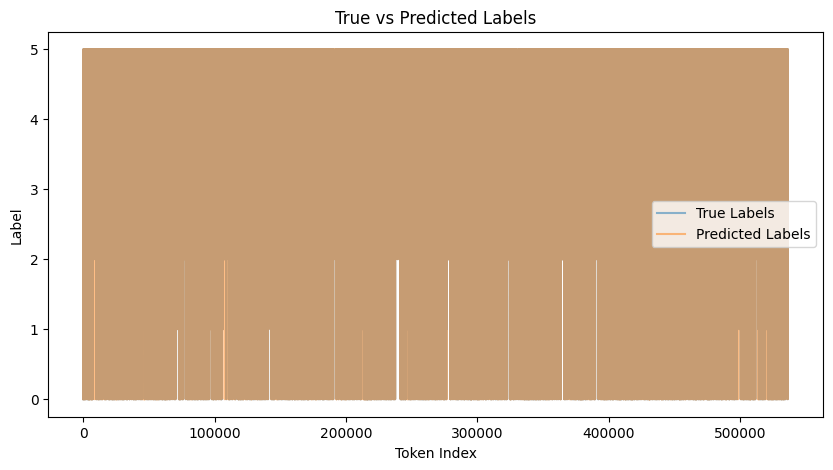

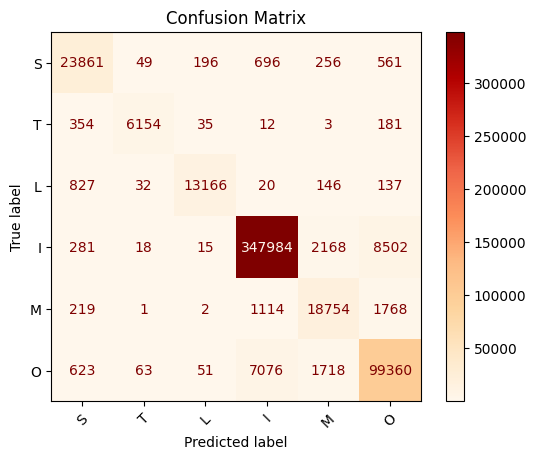

NameError: name 'writer' is not defined

In [18]:
# Evaluation

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import matplotlib.pyplot as plt
import numpy as np
import torch


model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v4.pt", map_location=DEVICE))


val_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF (pass labels)
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += loss.item()

        # Decode predictions using CRF (no labels passed)
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)  # List[List[int]]

        # Loop through batch and collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())


# Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

# F1 Score weighted
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")
# F1 Score macro
f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1_macro:.4f}")

# Sequence Level Accuracy
seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Token-level Accuracy
token_acc = accuracy_score(all_labels, all_preds)
print(f"Token-level Accuracy: {token_acc:.4f}")

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(all_labels)), all_labels, label='True Labels', alpha=0.5)
plt.plot(range(len(all_preds)), all_preds, label='Predicted Labels', alpha=0.5)
plt.title("True vs Predicted Labels")
plt.xlabel("Token Index")
plt.ylabel("Label")
plt.legend()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

writer.add_scalar("Loss/test", val_loss)

writer.flush()
writer.close()


In [ ]:
import torch
from torchviz import make_dot
from torchview import draw_graph

# Load the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v3.pt"))
model.eval()

# Create dummy inputs matching the expected dimensions
batch_size = 1
seq_length = 512  # maximum token length
dummy_input_ids = torch.randint(0, 1000, (batch_size, seq_length)).to(DEVICE)  
dummy_attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long).to(DEVICE)
# Create dummy labels for the CRF loss computation; filling with -100 so that loss is computed correctly
dummy_labels = torch.full((batch_size, seq_length), -100, dtype=torch.long).to(DEVICE)

# Set the model to evaluation mode
model.eval()

# --- Visualization using torchviz ---
# Forward pass to compute a loss (required for torchviz to trace the graph)
dummy_loss = model(dummy_input_ids, dummy_attention_mask, dummy_labels)
dot = make_dot(dummy_loss, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_visualization_torchviz', view=False)  # Save the graph image without opening it automatically

# --- Visualization using torchview ---
# Draw and display the model graph (adjust parameters as needed)
draw_graph(model, input_size=(batch_size, seq_length), device=DEVICE)